In [1]:
%matplotlib inline

HW 11 L 11

Course project:
- Transfer learning for your dataset on a chosen pretrained model
- Construct your own simple architecture and train it on your dataset

USE: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import torchvision
from torchvision.io import read_image
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from pathlib import Path
from typing import Dict, List, Text, Optional, Tuple
from PIL import Image
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1
Torchvision Version:  0.15.2


## Inputs

### Data Set

1. Business Meeting Office: 
https://drive.google.com/drive/folders/1-0rERtNvkF45qllgWtUYprvZEYnCBPfQ?usp=share_link
2. Workplace Productivity:
https://drive.google.com/drive/folders/19g1sxD7eUDDWn_JlXjrSfvvcWCSnQYaV?usp=share_link
3. Teambuilding:
https://drive.google.com/drive/folders/1F3G5p9iUF6X-dEA5HKZ4x_PS-TSsIQkA?usp=share_link

### Available models
- resnet
- alexnet
- vgg
- squeezenet
- densenet
- inception
- mobilenet
- efficientnet

See: https://pytorch.org/vision/stable/models.html



In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Loading training and testing folders using ImageFolder

In [4]:
train_dataset = torchvision.datasets.ImageFolder(
    root='./train',
    transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(
    root='./test',
    transform=test_transform)

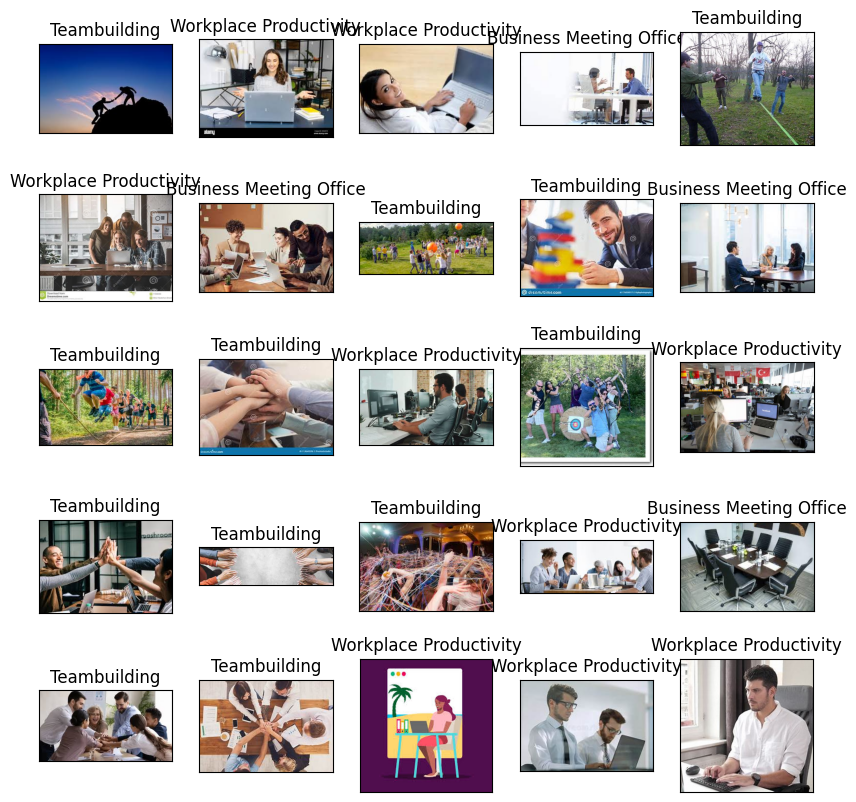

In [5]:
fig = plt.figure(figsize=(10, 10))
visualize_dataset = torchvision.datasets.ImageFolder(root='./train')
rows, columns = 5, 5
rand_indeces = np.random.randint(low=0, high=len(visualize_dataset), size=(rows*columns,))

images = []
labels = []

for i in rand_indeces:
    img, class_ = visualize_dataset[i]
    images.append(img)
    labels.append(visualize_dataset.classes[class_])

# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{labels[i-1]}")


In [8]:
from torchvision.models import ResNet18_Weights

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


# Number of classes in the dataset
num_classes = len(train_dataset.classes)

# Batch size for training (change depending on how much memory you have)
batch_size = 128

# Number of epochs to train for 
num_epochs = 15

# Device for running training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
# model = models.resnet18(pretrained=True)
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Training only the last layer, the other layers are freezed
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
print(f"{num_ftrs = }")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/mac/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


num_ftrs = 512


In [9]:
num_classes

3

## Helper Functions

In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    train_acc_history = []
    train_loss_history = []

    val_acc_history = []
    val_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    y_pred_proba = torch.softmax(outputs, dim=1)
                    y_pred = y_pred_proba.argmax(dim=1)
                    # print(f"{y_pred = }")
                    # print(f"{labels = }")
                    # print(f"{y_pred.shape = }")
                    # print(f"{labels.shape = }")
                    # loss = criterion(y_pred_proba, labels)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # print(f"{preds = }")
                # print(f"{labels.data = }")
                running_corrects += torch.sum(y_pred == labels)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

## Load Data


In [11]:
# Create training and validation datasets

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Create training and validation dataloaders
dataloaders_dict = {
    "train": train_dataloader,
    "val": test_dataloader,
}



## Create the Optimizer


In [12]:
# Send the model to GPU
model = model.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params=model.parameters())

## Run Training and Validation Step


In [13]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, val_acc_history, val_loss_history, train_acc_history, train_loss_history = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.9101 Acc: 0.5857
val Loss: 0.6221 Acc: 0.7787

Epoch 1/14
----------
train Loss: 0.6041 Acc: 0.7767
val Loss: 0.4970 Acc: 0.8173

Epoch 2/14
----------
train Loss: 0.5329 Acc: 0.7983
val Loss: 0.4846 Acc: 0.8013

Epoch 3/14
----------
train Loss: 0.5068 Acc: 0.8063
val Loss: 0.4338 Acc: 0.8333

Epoch 4/14
----------
train Loss: 0.4861 Acc: 0.8133
val Loss: 0.4222 Acc: 0.8293

Epoch 5/14
----------
train Loss: 0.4547 Acc: 0.8237
val Loss: 0.4101 Acc: 0.8387

Epoch 6/14
----------
train Loss: 0.4507 Acc: 0.8270
val Loss: 0.4034 Acc: 0.8373

Epoch 7/14
----------
train Loss: 0.4369 Acc: 0.8387
val Loss: 0.3969 Acc: 0.8507

Epoch 8/14
----------
train Loss: 0.4257 Acc: 0.8377
val Loss: 0.3966 Acc: 0.8440

Epoch 9/14
----------
train Loss: 0.4171 Acc: 0.8483
val Loss: 0.3982 Acc: 0.8427

Epoch 10/14
----------
train Loss: 0.4157 Acc: 0.8437
val Loss: 0.3968 Acc: 0.8387

Epoch 11/14
----------
train Loss: 0.4079 Acc: 0.8460
val Loss: 0.3872 Acc: 0.8493

Ep

In [14]:
val_acc_history_cpu = [i.item() for i in val_acc_history]
val_loss_history_cpu = val_loss_history
train_acc_history_cpu = [i.item() for i in train_acc_history]
train_loss_history_cpu = train_loss_history

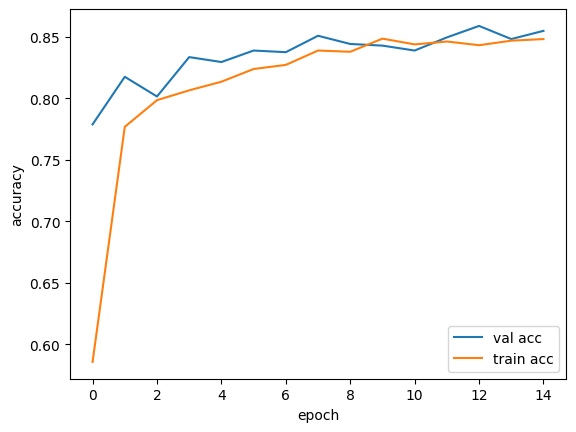

In [15]:
plt.plot(val_acc_history_cpu, label="val acc")
plt.plot(train_acc_history_cpu, label="train acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

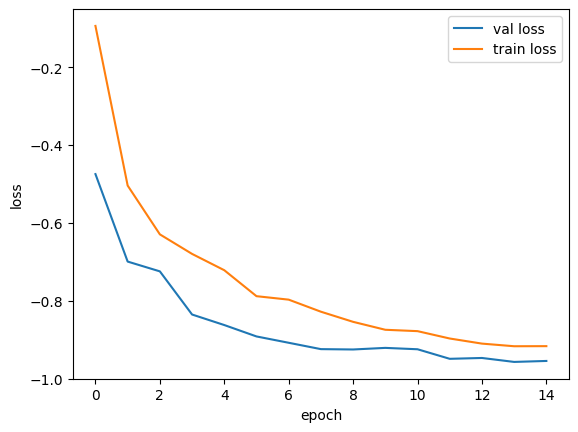

In [16]:
plt.plot(np.log(np.array(val_loss_history_cpu)), label="val loss")
plt.plot(np.log(np.array(train_loss_history_cpu)), label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

So, the ResNet-18 model give more than 85% accuracy after 14 epochsand it takes 31 mins to train. Let's try constructing our own simple architecture and train it on our dataset. First, I proceed with a simple CNN, leting it learn in a considerable amount of time.


Epoch 0/14
----------
train Loss: 1.0775 Acc: 0.5480
val Loss: 0.9234 Acc: 0.6053

Epoch 1/14
----------
train Loss: 0.8377 Acc: 0.6077
val Loss: 0.7950 Acc: 0.6120

Epoch 2/14
----------
train Loss: 0.7679 Acc: 0.6487
val Loss: 0.7536 Acc: 0.6493

Epoch 3/14
----------
train Loss: 0.7486 Acc: 0.6723
val Loss: 1.1918 Acc: 0.5973

Epoch 4/14
----------
train Loss: 0.7518 Acc: 0.6707
val Loss: 0.7089 Acc: 0.6893

Epoch 5/14
----------
train Loss: 0.7155 Acc: 0.6930
val Loss: 0.7040 Acc: 0.6547

Epoch 6/14
----------
train Loss: 0.6927 Acc: 0.7030
val Loss: 1.1332 Acc: 0.5027

Epoch 7/14
----------
train Loss: 0.6765 Acc: 0.7123
val Loss: 0.8130 Acc: 0.6507

Epoch 8/14
----------
train Loss: 0.6839 Acc: 0.7093
val Loss: 0.7209 Acc: 0.6827

Epoch 9/14
----------
train Loss: 0.6475 Acc: 0.7240
val Loss: 0.6619 Acc: 0.7280

Epoch 10/14
----------
train Loss: 0.6309 Acc: 0.7430
val Loss: 0.6861 Acc: 0.6920

Epoch 11/14
----------
train Loss: 0.6294 Acc: 0.7420
val Loss: 0.6702 Acc: 0.7053

Ep

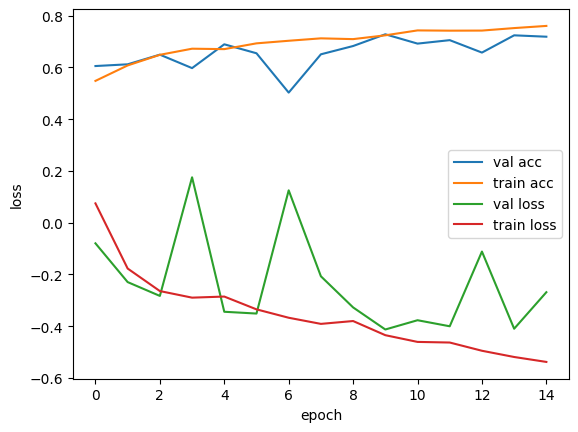

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        layers = [ResidualBlock(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Create an instance of the CustomResNet
custom_resnet_model = CustomResNet(num_classes)

# Send the model to the GPU if available
custom_resnet_model = custom_resnet_model.to(device)

# Define optimizer and loss function
optimizer_custom_resnet = optim.Adam(params=custom_resnet_model.parameters())
criterion_custom_resnet = nn.CrossEntropyLoss()

# Train and evaluate the custom ResNet model
custom_resnet_model, custom_resnet_val_acc_history, custom_resnet_val_loss_history, custom_resnet_train_acc_history, custom_resnet_train_loss_history = train_model(
    custom_resnet_model, dataloaders_dict, criterion_custom_resnet, optimizer_custom_resnet, num_epochs=num_epochs)

# Plot accuracy and loss for the custom ResNet model
plt.plot(custom_resnet_val_acc_history, label="val acc")
plt.plot(custom_resnet_train_acc_history, label="train acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

plt.plot(np.log(np.array(custom_resnet_val_loss_history)), label="val loss")
plt.plot(np.log(np.array(custom_resnet_train_loss_history)), label="train loss")
plt.xlabel("epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()


The best testing accuracy is somehow poor (72.8%). That's pretty expected for this relatively simple CNN with batch norm and residual block. For the course project, I still experiment with other architectures.